In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import embedders

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geoopt

# Decorator

/Users/phil/miniforge3/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


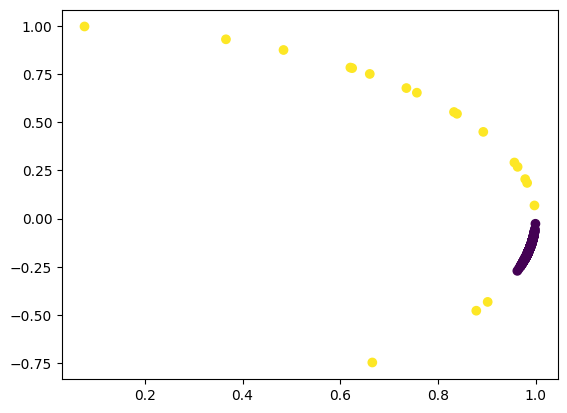

In [3]:
# Decorator: does ReLU work?

sph = embedders.manifolds.ProductManifold(signature=[(1, 1)])
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=sph)

# Plot X points originally
X_np = X.detach().numpy()
y_np = y.detach().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np)

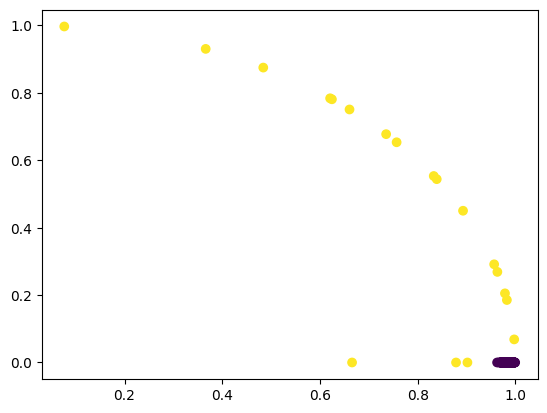

False


In [4]:
# ReLU normal

relu = torch.nn.ReLU()

X_relu = relu(X)
X_relu_np = X_relu.detach().numpy()

# Plot X points after ReLU
plt.scatter(X_relu_np[:, 0], X_relu_np[:, 1], c=y_np)
plt.show()

print(sph.manifold.check_point_on_manifold(X_relu))

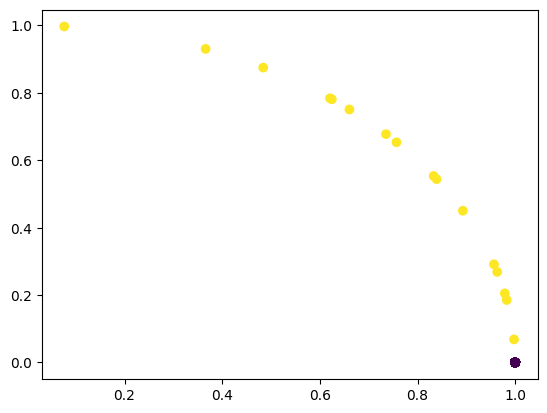

True


In [5]:
# ReLU with manifold-apply


@sph.apply
def relu(x):
    return torch.relu(x)


X_relu = relu(X)
X_relu_np = X_relu.detach().numpy()

# Plot X points after ReLU
plt.scatter(X_relu_np[:, 0], X_relu_np[:, 1], c=y_np)
plt.show()

print(sph.manifold.check_point_on_manifold(X_relu))

In [6]:
# Verify it works on a product manifold too

M = embedders.manifolds.ProductManifold(signature=[(2, 2), (0, 2), (-2, 2)])
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=M)

In [7]:
@M.apply
def relu(x):
    return torch.relu(x)


X_relu = relu(X)

print((X_relu < 0).any())

tensor(True)


# How to make stereographic projections?

In [3]:
M = embedders.manifolds.ProductManifold(signature=[(2, 2), (0, 2), (-2, 2)])
S, E, H = M.P

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=M)
X_S, X_E, X_H = M.factorize(X)
y_np = y.detach().numpy()

/Users/phil/miniforge3/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [9]:
# Sanity check
print(S.type, E.type, H.type)

S E H


In [4]:
# A spherical stereographic manifold

D = geoopt.manifolds.Stereographic(2)

NameError: name 'geoopt' is not defined

In [5]:
# Try to convert S to kappa-stereographic model using geoopt

# D = S.to_stereographic()
# D = embedders.manifolds.Manifold(curvature=1, dim=1, stereographic=True)
# P = embedders.manifolds.Manifold(curvature=-1, dim=1, stereographic=True)

D, X_D = S.stereographic(X_S)

# Plot new X
X_D_np = X_D.detach().numpy()

plt.scatter(X_D_np[:, 0], X_D_np[:, 1], c=y.detach().numpy())
plt.show()

NameError: name 'plt' is not defined

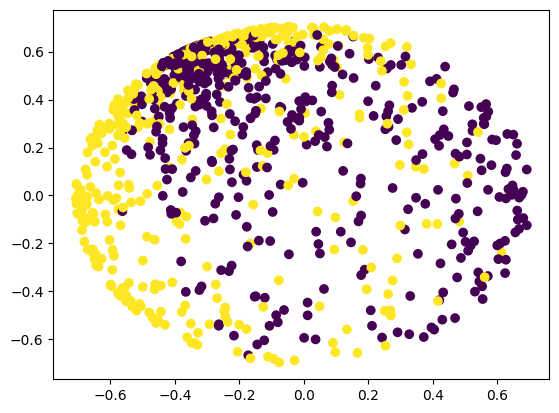

In [15]:
# Try to convert H to kappa-stereographic model using geoopt

P, X_P = H.stereographic(X_H)

# Plot new X
X_P_np = X_P.detach().numpy()

plt.scatter(X_P_np[:, 0], X_P_np[:, 1], c=y.detach().numpy())
plt.show()

In [19]:
# Verify that mu0 becomes 0 in stereographic projection

_, mu0_P = H.stereographic(H.mu0)
print(mu0_P)

_, mu0_D = S.stereographic(S.mu0)
print(mu0_D)

tensor([[0., 0.]])
tensor([[0., 0.]])


# Stereographic product manifold

In [50]:
# Verify that we can initialize a stereographic product manifold
# Verify that we can convert to a stereo product manifold
# Verify projection matrix becomes identity matrix

import embedders.manifolds


M = embedders.manifolds.ProductManifold(signature=[(2, 2), (0, 2), (-2, 2)])
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=M)

In [54]:
M_stereo, X_stereo = M.stereographic(X)

In [52]:
X_stereo

tensor([[ 0.8822, -0.8913,  0.6422,  3.2698,  0.5934,  0.3838],
        [-0.4060, -0.8125, -2.1625,  0.5253, -0.5140, -0.4160],
        [ 0.6936, -0.0564,  0.9147, -0.7366, -0.1943, -0.3989],
        ...,
        [-0.0869, -0.8686, -1.6935,  1.0487, -0.4835, -0.4502],
        [24.4561,  0.8880, -4.5243,  0.6087,  0.5169,  0.4045],
        [ 0.5425,  0.1812, -5.6898,  0.8976,  0.5311,  0.3585]])

In [53]:
M_stereo.factorize(X_stereo)

[tensor([[ 0.8822, -0.8913],
         [-0.4060, -0.8125],
         [ 0.6936, -0.0564],
         ...,
         [-0.0869, -0.8686],
         [24.4561,  0.8880],
         [ 0.5425,  0.1812]]),
 tensor([[ 0.6422,  3.2698],
         [-2.1625,  0.5253],
         [ 0.9147, -0.7366],
         ...,
         [-1.6935,  1.0487],
         [-4.5243,  0.6087],
         [-5.6898,  0.8976]]),
 tensor([[ 0.5934,  0.3838],
         [-0.5140, -0.4160],
         [-0.1943, -0.3989],
         ...,
         [-0.4835, -0.4502],
         [ 0.5169,  0.4045],
         [ 0.5311,  0.3585]])]

# $\kappa$-GCN logits implementation
Per "Constant Curvature Graph Convolutional Networks" (Bachmann et al 2020), logits are defined as

$$
p(y = k\ |\ \mathbf{x}) = \operatorname{Softmax}\left( 
    \frac{
        \|\mathbf{a}_k\|\mathbf{p}_k
    }{
        \sqrt{|\kappa|}
    }
    \sin_\kappa^{-1}\left(
        \frac{
            2\sqrt{|\kappa|}\langle \mathbf{z}_k, \mathbf{a}_k \rangle
        }{
            (1 + \kappa\|\mathbf{z}_k \|^2)\|\mathbf{a}_k\|
        }
    \right)
\right)
$$

Where:
* $\mathbf{z}_k$ is $-\mathbf{p}_k \oplus_\kappa \mathbf{x}$
* $\mathbf{a} \in \mathbb{R}^d$
* $\mathbf{p}_k \in \mathcal{M}$
* $\sin_\kappa(\cdot) = \sinh(\cdot)$ if $\kappa < 0$, else $\sin(\cdot)$

/Users/phil/miniforge3/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


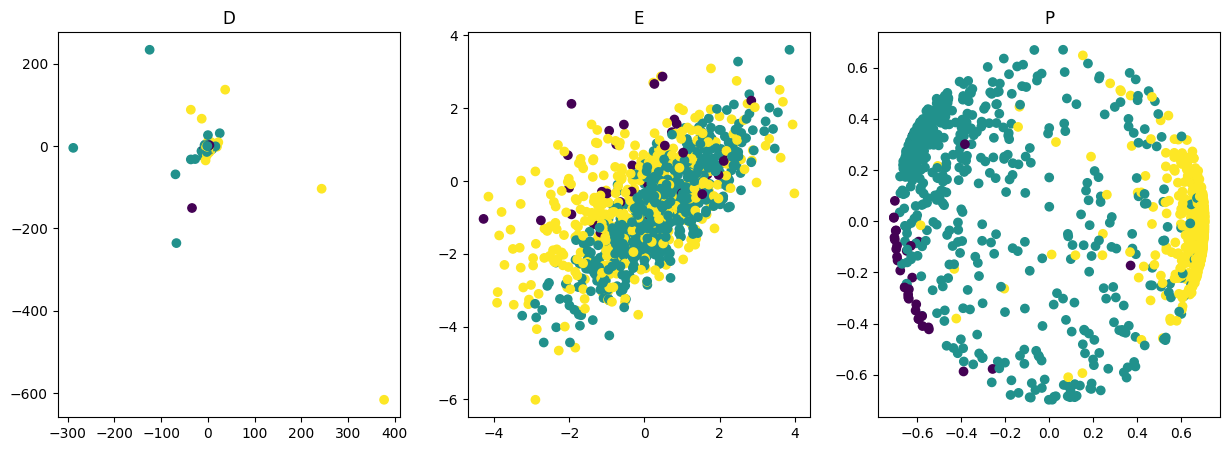

In [105]:
# Let's start with a basic product manifold
import embedders
import matplotlib.pyplot as plt
import torch

# Make a manifold
M = embedders.manifolds.ProductManifold(signature=[(2, 2), (0, 2), (-2, 2)])
S, E, H = M.P

# Get points
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=M, num_classes=3)
X_S, X_E, X_H = M.factorize(X)

# Convert to stereographic
M_stereo, X_stereo = M.stereographic(X)
D, _, P = M_stereo.P
X_D, _, X_P = M_stereo.factorize(X_stereo)

# Let's also visualize our points
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, _X, title in zip(axs, [X_D, X_E, X_P], ["D", "E", "P"]):
    ax.scatter(_X[:, 0], _X[:, 1], c=y)
    ax.set_title(title)
plt.show()

In [53]:
# Let's start with our sphere
import geoopt

d = 2  # Number of dimensions
k = 2  # Number of classes
kappa = 2  # Curvature
man = D.manifold
mu0 = man.origin(d)

# Get a W and p_k that we can use
# W = torch.rand(d, k)
a_k = torch.rand(d)
p_k = X_D[torch.randint(len(X_D), (1,))].view(-1)

# Make these parameters
# W = torch.nn.Parameter(W)
a_k = torch.nn.Parameter(a_k)
p_k = geoopt.ManifoldParameter(p_k, manifold=man)

# Implement the logits step by step
# 1. Let's get z_k = -p_k \oplus_\kappa x
z_k = man.mobius_add(-p_k, X_D)
print(z_k.shape)

# 2. Get norms for relevant terms
# z_k_norm = man.norm(mu0, z_k)
# a_k_norm = man.norm(mu0, a_k)
# a_k_norm_from_p_k = man.norm(p_k, a_k)
z_k_norm = torch.norm(z_k)
a_k_norm = torch.norm(a_k)

# 3. Get the argument for sin_kappa^-1
num = 2 * abs(kappa) ** 0.5 * man.inner(z_k, a_k)
denom = (1 + kappa * z_k_norm**2) * a_k_norm
arg = num / denom

# 4. Get the right-hand side
sin_kappa_inv = torch.asin if kappa >= 0 else torch.asinh
rhs = sin_kappa_inv(arg)

# 5. Get the left-hand side
lambda_pk = man.lambda_x(p_k)
lhs = lambda_pk * a_k_norm / abs(kappa) ** 0.5
# lhs = a_k_norm_from_p_k / abs(kappa) ** 0.5

# 6. Get the logits
logits = lhs * rhs
print(logits)

# 7. Get the probabilities
# probs = torch.softmax(logits, dim=1)
# print(probs)

torch.Size([1000, 2])
tensor([[4.0217e-05],
        [1.6715e-05],
        [8.8175e-05],
        [4.2109e-05],
        [4.4074e-05],
        [2.8851e-05],
        [6.7114e-05],
        [1.0222e-04],
        [1.1266e-04],
        [1.2584e-05],
        [4.4855e-06],
        [4.4435e-06],
        [5.6864e-05],
        [6.5488e-06],
        [1.1662e-04],
        [7.3977e-05],
        [4.5558e-06],
        [1.2199e-04],
        [1.4225e-06],
        [2.5462e-05],
        [9.3770e-05],
        [1.8080e-05],
        [1.5190e-04],
        [1.2207e-04],
        [1.0637e-05],
        [1.0057e-05],
        [1.3651e-04],
        [4.2530e-05],
        [6.6082e-05],
        [4.1238e-06],
        [1.1380e-04],
        [1.3595e-04],
        [1.0513e-05],
        [1.5801e-04],
        [6.9394e-05],
        [2.4719e-05],
        [4.6926e-05],
        [1.3705e-04],
        [1.1298e-04],
        [1.1591e-04],
        [2.4500e-05],
        [2.4573e-05],
        [5.3495e-05],
        [1.0140e-05],
        [1

In [ ]:
# Cleaned up version

# Let's start with our sphere
import geoopt

d = 2  # Number of dimensions
k = 3  # Number of classes
n = len(X_D)  # Number of points
kappa = 2  # Curvature
man = D.manifold
mu0 = man.origin(d)

# Get a W and p_k that we can use
W = torch.rand(d, k) * 100
p_ks = X_D[torch.randint(len(X_D), (k,))]

# Make these parameters
W = torch.nn.Parameter(W)
p_ks = geoopt.ManifoldParameter(p_ks, manifold=man)

# Implement the logits step by step
logits = torch.zeros(n, k)
for class_idx in range(k):
    # 0. Get parameters
    a_k = W[:, class_idx]
    p_k = p_ks[class_idx]

    # 1. Let's get z_k = -p_k \oplus_\kappa x
    z_k = man.mobius_add(-p_k, X_D)

    # 2. Get norms for relevant terms
    z_k_norm = torch.norm(z_k)
    a_k_norm = torch.norm(a_k)

    # 3. Get the argument for sin_kappa^-1
    num = 2 * abs(kappa) ** 0.5 * man.inner(z_k, a_k)
    denom = (1 + kappa * z_k_norm**2) * a_k_norm
    arg = num / denom

    # 4. Get the right-hand side
    sin_kappa_inv = torch.asin if kappa >= 0 else torch.asinh
    rhs = sin_kappa_inv(arg)

    # 5. Get the left-hand side
    lambda_pk = man.lambda_x(p_k)
    lhs = lambda_pk * a_k_norm / abs(kappa) ** 0.5

    # 6. Get the logits
    logits[:, class_idx] = (lhs * rhs).flatten()

probs = torch.softmax(logits, dim=1)
print(probs)

tensor([[5.1737e-01, 2.0963e-01, 2.7300e-01],
        [1.4045e-02, 9.6252e-01, 2.3437e-02],
        [2.7756e-01, 5.3784e-01, 1.8460e-01],
        ...,
        [1.2407e-04, 9.7647e-01, 2.3401e-02],
        [1.2068e-02, 8.7399e-01, 1.1394e-01],
        [4.5017e-01, 3.3838e-01, 2.1145e-01]], grad_fn=<SoftmaxBackward0>)


In [92]:
# Let's start with our sphere
import geoopt

d = 2  # Number of dimensions
k = 3  # Number of classes
n = len(X_D)  # Number of points
kappa = 2  # Curvature
man = D.manifold
mu0 = man.origin(d)

# Get a W and p_k that we can use
W = torch.rand(d, k) * 100
p_ks = X_D[torch.randint(len(X_D), (k,))]

# Make these parameters
W = torch.nn.Parameter(W)
p_ks = geoopt.ManifoldParameter(p_ks, manifold=man)

In [93]:
# Let's make a function


# Implement the logits step by step
def get_logits(man, X, W, b):
    k = W.shape[1]
    n = X.shape[0]
    kappa = man.curvature
    logits = torch.zeros(n, k)
    for class_idx in range(k):
        # 0. Get parameters
        a_k = W[:, class_idx]
        p_k = b[class_idx]

        # 1. Let's get z_k = -p_k \oplus_\kappa x
        z_k = man.manifold.mobius_add(-p_k, X)

        # 2. Get norms for relevant terms
        z_k_norm = torch.norm(z_k)
        a_k_norm = torch.norm(a_k)

        # 3. Get the argument for sin_kappa^-1
        num = 2 * abs(kappa) ** 0.5 * man.manifold.inner(z_k, a_k)
        denom = (1 + kappa * z_k_norm**2) * a_k_norm
        arg = num / denom

        # 4. Get the right-hand side
        sin_kappa_inv = torch.asin if kappa >= 0 else torch.asinh
        rhs = sin_kappa_inv(arg)

        # 5. Get the left-hand side
        lambda_pk = man.manifold.lambda_x(p_k)
        lhs = lambda_pk * a_k_norm / abs(kappa) ** 0.5

        # 6. Get the logits
        logits[:, class_idx] = (lhs * rhs).flatten()

    return logits


# Let's test it
get_logits(D, X_D, W, p_ks)

tensor([[0.0419, 0.0306, 0.3435],
        [0.0132, 0.0067, 0.2248],
        [0.6346, 0.2188, 0.4702],
        ...,
        [1.1637, 0.3858, 0.5221],
        [1.9707, 0.7402, 0.5944],
        [4.2690, 1.1980, 0.1042]], grad_fn=<CopySlices>)

In [112]:
# Hyperparams
LR = 3e-4
BATCH_SIZE = 128
EPOCHS = 10_000

# Reinitialize W and p_ks
W = torch.nn.Parameter(torch.rand(d, k))
p_ks = geoopt.ManifoldParameter(X_D[torch.randint(len(X_D), (k,))], manifold=D.manifold)

# Make optimizers
opt = torch.optim.Adam([W], lr=LR)
ropt = geoopt.optim.RiemannianAdam([p_ks], lr=LR)
loss = torch.nn.CrossEntropyLoss()

for i in range(EPOCHS):
    # Get a batch
    idx = torch.randint(len(X_D), (BATCH_SIZE,))
    X_D_batch = X_D[idx]
    y_batch = y[idx]

    # Get logits
    opt.zero_grad()
    ropt.zero_grad()
    logits = get_logits(D, X_D_batch, W, p_ks)
    l = loss(logits, y_batch)
    l.backward()

    if not l.isnan():
        opt.step()
        ropt.step()
    else:
        print("Loss is NaN")

    if i % 1_000 == 0:
        print(f"Loss: {l}")

Loss: 1.1019012928009033
Loss: 1.098127007484436
Loss: 1.092971920967102
Loss: 1.091001272201538
Loss: 1.0855610370635986
Loss: 1.0848779678344727
Loss: 1.085050106048584
Loss: 1.0725165605545044
Loss: 1.0780506134033203
Loss: 1.0570273399353027


In [130]:
# Score the model
logits = get_logits(D, X_D, W, p_ks)
preds = torch.argmax(logits, dim=1)
acc = (preds == y).float().mean()
print(f"Accuracy: {acc}")

Accuracy: 0.4860000014305115


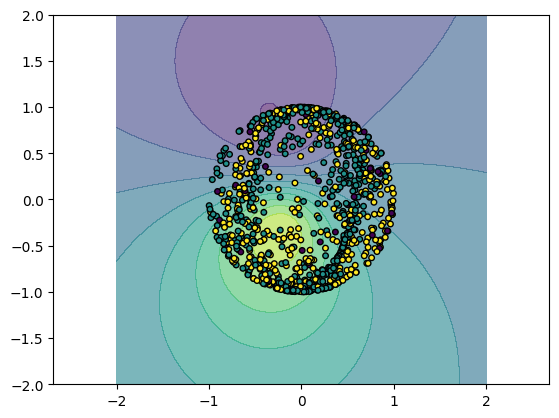

In [155]:
# Visualize predictions

# _xmin, _xmax = X_D[:, 0].min(), X_D[:, 0].max()
# _ymin, _ymax = X_D[:, 1].min(), X_D[:, 1].max()
_xmin, _xmax = -2, 2
_ymin, _ymax = -2, 2

_x = torch.linspace(_xmin, _xmax, 100)
_y = torch.linspace(_ymin, _ymax, 100)
_xx, _yy = torch.meshgrid(_x, _y)
_X = torch.stack([_xx.flatten(), _yy.flatten()], dim=1)

logits = get_logits(D, _X, W, p_ks)
# preds = torch.argmax(logits, dim=1)
preds = torch.softmax(logits, dim=1)[:, 1].view(100, 100).detach().numpy()

plt.contourf(_xx, _yy, preds, alpha=0.6, levels=10)
plt.scatter(X[:, 0], X[:, 1], c=y, s=16, edgecolor="k", linewidth=1)
# equal aspect ratio
plt.axis("equal")
plt.show()

# $\kappa$-GCN layer implementation

Per the paper, we want to implement this:

$$
\mathbf{H}^{(l+1)} = \sigma^{\otimes_\kappa}\left( 
    \mathbf{\hat{A}} \boxtimes_\kappa \left(
        \mathbf{H}^{(l)} \otimes_\kappa \mathbf{W}^{(l)}
    \right)
\right)
$$

And the final layer is

$$
\mathbf{H}^{(L)} = \operatorname{softmax}\left(
    \mathbf{\hat{A}} \operatorname{logit}_\kappa\left(
        \mathbf{H}^{(L-1)}, \mathbf{W}^{(L-1)}
    \right)
\right)
$$

Additionally, we define $\mathbf{\hat{A}}$:

$$
\mathbf{\hat{A}} = \mathbf{\tilde{D}}^{-1/2} \mathbf{\tilde{A}} \mathbf{\tilde{D}}^{-1/2}
$$

In [12]:
import embedders

In [13]:
# First, we need to get some kind of adjacency matrix

dists, labels, adj = embedders.dataloaders.load("polblogs")

Top CC has 1222 nodes; original graph has 1490 nodes.


According to the geoopt documentation, `manifold.weighted_midpoint` implements a single weighted midpoint:

$$
        m_{\kappa}(x_1,\ldots,x_n,\alpha_1,\ldots,\alpha_n)
        =
        \frac{1}{2}
        \otimes_\kappa
        \left(
        \sum_{i=1}^n
        \frac{
        \alpha_i\lambda_{x_i}^\kappa
        }{
        \sum_{j=1}^n\alpha_j(\lambda_{x_j}^\kappa-1)
        }
        x_i
        \right)
$$

Therefore, we will need to define our own, row-wise left-matrix product in `left_multiply`

In [66]:
# Get the matrices you need
A = adj
A_tilde = A + torch.eye(A.shape[0])  # adjacency matrix with self-loops
D_tilde = torch.diag(torch.sum(A, dim=1))  # diagonal matrix of degrees
D_tilde_invsqrt = D_tilde.inverse() ** 0.5  # inverse square root of D_tilde
A_hat = D_tilde_invsqrt**0.5 @ A_tilde @ D_tilde_invsqrt  # normalized adjacency matrix


# Define a vanilla GCN layer
class GCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = torch.nn.Parameter(torch.rand(in_features, out_features))
        self.b = torch.nn.Parameter(torch.rand(out_features))

    def forward(self, X, A_hat):
        return A_hat @ X @ self.W + self.b


# Example of a GCN
gcn = torch.nn.Sequential(GCNLayer(2, 16), torch.nn.ReLU(), GCNLayer(16, 2))


# A kappa-GCN layer
class KappaGCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, manifold, nonlinearity=torch.relu):
        super().__init__()

        # Parameters are Euclidean, straightforardly
        self.W = torch.nn.Parameter(torch.rand(in_features, out_features))
        # self.b = torch.nn.Parameter(torch.rand(out_features))

        # Noninearity must be applied via wrapper
        if nonlinearity is None:
            self.sigma = lambda x: x
        else:

            @manifold.apply
            def sigma(x):
                return nonlinearity(x)

            self.sigma = sigma

        # Also store manifold
        self.manifold = manifold

    def left_multiply(self, A, X):
        out = torch.zeros_like(X)
        for i, (A_i, X_i) in enumerate(zip(A, X)):
            m_i = self.manifold.manifold.weighted_midpoint(xs=X_i, weights=A_i)
            out[i] = self.manifold.manifold.mobius_scalar_mul(r=A_i.sum(), x=m_i)
        return out

    def forward(self, X, A_hat):
        # 1. right-multiply X by W - mobius_matvec broadcasts correctly (verified)
        XW = self.manifold.manifold.mobius_matvec(m=self.W, x=X)

        # 2. left-multiply (X @ W) by A_hat - we need our own implementation for this
        AXW = self.left_multiply(A_hat, XW)

        # 3. Apply nonlinearity - note that sigma is wrapped with our manifold.apply decorator
        AXW = self.sigma(AXW)

        return AXW

In [36]:
# Does mobius_matvec work for two matrices, or do we need to loop it?
import geoopt
import torch

# man = geoopt.manifolds.StereographicProductManifold(
#     (geoopt.manifolds.Stereographic(1), 2),
#     (geoopt.manifolds.Stereographic(1), 2),
#     (geoopt.manifolds.Stereographic(-1), 2)
# )

# X = man.expmap0(torch.rand(20, 6)) # 20 points in our manifold
# W = torch.rand(6, 6) # Weight matrix

man = geoopt.manifolds.Stereographic(2)
X = man.expmap0(torch.rand(len(A_hat), 2))  # 20 points in our manifold
W = torch.rand(2, 2)  # Start with a square matrix

# M is left side, x is right side
# X gets broken up into row vectors (denoted by x in geoopt, we can call it X_i consistent with Bachmann)
# Note that the syntax of mobius_matvec is reversed from the Bachmann paper
XW = man.mobius_matvec(W, X)
XW_rowwise = torch.zeros(len(A_hat), 2)
for i, X_i in enumerate(X):
    XW_rowwise[i] = man.mobius_matvec(W, X_i)
print(torch.allclose(XW, XW_rowwise, atol=1e-3))

# Left-product
AXW = kappa_left_multiply(A_hat, XW, manifold=man)

True


In [71]:
# Let's try to build a kappa-GCN model


class KappaGCN(torch.nn.Module):
    def __init__(self, in_features, out_features, manifold, nonlinearity=torch.relu):
        super().__init__()
        self.layer = KappaGCNLayer(in_features, in_features, manifold, nonlinearity)
        self.manifold = manifold

        # Final layer params
        self.W_logits = torch.nn.Parameter(torch.rand(in_features, out_features))
        self.p_ks = geoopt.ManifoldParameter(
            manifold.expmap(torch.rand(out_features, in_features), base=None), manifold=manifold.manifold
        )

    def forward(self, X, A_hat, softmax=False):
        H0 = X
        H1 = self.layer(H0, A_hat)
        logits = get_logits(self.manifold, H1, self.W_logits, self.p_ks)
        logits_agg = A_hat @ logits
        if softmax:
            return torch.softmax(logits_agg, dim=1)
        else:
            return logits_agg

In [86]:
%%prun

from tqdm.notebook import tqdm

# Get some data
manifold = embedders.manifolds.ProductManifold(signature=[(1,2)])
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=manifold)
manifold_stereo, X_stereo = manifold.stereographic(X)

# Make a random adjacency matrix
A = torch.rand(len(X_stereo), len(X_stereo)) * torch.randint(0, 2, (len(X_stereo), len(X_stereo)))
A = A + A.T
A_tilde = A + torch.eye(A.shape[0])  # adjacency matrix with self-loops
D_tilde = torch.diag(torch.sum(A, dim=1))  # diagonal matrix of degrees
D_tilde_invsqrt = D_tilde.inverse() ** 0.5  # inverse square root of D_tilde
A_hat = D_tilde_invsqrt**0.5 @ A_tilde @ D_tilde_invsqrt  # normalized adjacency matrix

# Instantiate the model
kgcn = KappaGCN(
    in_features=2,
    out_features=2,
    manifold=manifold_stereo.P[0],
    nonlinearity=torch.relu
)
kgcn(X_stereo, A_hat)

# Let's train the model
opt = torch.optim.Adam(kgcn.parameters(), lr=1e-1)
ropt = geoopt.optim.RiemannianAdam([kgcn.p_ks], lr=1e-1)
loss = torch.nn.CrossEntropyLoss()

EPOCHS = 100
my_tqdm = tqdm(total=EPOCHS)
for i in range(EPOCHS):
    # Get logits
    opt.zero_grad()
    ropt.zero_grad()
    logits = kgcn(X_stereo, A_hat, softmax=False)
    l = loss(logits, y)
    l.backward()

    if not l.isnan():
        opt.step()
        ropt.step()
    else:
        print("Loss is NaN")

    my_tqdm.update(1)
    my_tqdm.set_postfix({"Loss": l.item()})

/Users/phil/miniforge3/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


  0%|          | 0/100 [00:00<?, ?it/s]

         1333385 function calls (1331531 primitive calls) in 123.254 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100   69.099    0.691   69.099    0.691 {method 'run_backward' of 'torch._C._EngineBase' objects}
   101000   35.060    0.000   35.060    0.000 math.py:1876(weighted_midpoint)
   101000    6.164    0.000    6.165    0.000 math.py:756(mobius_scalar_mul)
        1    5.819    5.819  123.258  123.258 <string>:1(<module>)
   202505    4.489    0.000    4.490    0.000 math.py:290(project)
      101    0.991    0.010   47.663    0.472 4013776597.py:47(left_multiply)
      206    0.266    0.001    0.270    0.001 {method 'unbind' of 'torch._C.TensorBase' objects}
   101003    0.228    0.000    0.242    0.000 {method 'sum' of 'torch._C.TensorBase' objects}
   101000    0.212    0.000   37.579    0.000 manifold.py:526(weighted_midpoint)
   101000    0.182    0.000    8.592    0.000 manifold.py:271(mobius_scalar_m

In [87]:
# Implementation used in Curve Your Attention paper
# Source: https://openreview.net/forum?id=AN5uo4ByWH (supplementary materials)


class StereographicLogits(nn.Module):
    def __init__(self, manifold, input_dim, n_classes, c, num_heads):
        super().__init__()

        self.manifold = manifold
        self.n_classes = n_classes
        self.c = c
        self.num_heads = num_heads

        self.a = nn.parameter.Parameter(torch.randn(1, n_classes, input_dim) * 0.01)
        self.p = nn.parameter.Parameter(torch.zeros(1, n_classes, input_dim))

    def forward(self, x):
        if len(self.c) == 1:
            curv = self.c.repeat(self.num_heads)
        else:
            curv = self.c

        # a is the weight matrix; it gets split by submanifold
        a, c = self.manifold.split(self.a, curv)

        # p is the bias; it also gets split by submanifold
        p, _ = self.manifold.split(self.p, curv)

        # x is just the input; unsurprisingly, it also gets split by submanifold
        x, _ = self.manifold.split(x, curv)

        # p gets mapped from Euclidean space as follows: expmap0 -> project
        p = gmath.expmap0(p, k=c)
        p = gmath.project(p, k=c)

        # a gets parallel transported from tangent plane at the origin
        a = gmath.parallel_transport0(p, a, k=c)

        # compute z_k = -p \oplus x
        z = gmath.mobius_add(-p, x[:, None], k=c)

        # I'm not actually convinced we need this projection
        z = gmath.project(z, k=c)

        # compute the norm of a
        a_norm = a.pow(2).sum(dim=-1, keepdim=True).clamp_min(1e-15).sqrt()

        # This is the inner product of z and a, just written weird
        za = (z * a).sum(dim=-1, keepdim=True)

        # This is what we call "rhs"
        # Note that they're missing abs(c) ** 0.5 in the numerator - maybe it's in the arsin_k instead?
        h_dist = 2 * za / ((1 + c * z.pow(2).sum(dim=-1, keepdim=True)) * a_norm)
        h_dist = gmath.arsin_k(h_dist, k=c * c.abs())  # / c_sqrt

        # They need to square the distance because we need to aggregate across manifolds
        h_dist = h_dist.pow(2).sum(dim=-2, keepdim=True).clamp_min(1e-15).sqrt()

        # Tensor must have shape like (n_points, n_manifolds, n_dimensions)
        # 1. Compute conformal factors for a_norm across all curvatures
        # 2. Take l2 norm of these factors
        # 3. Multiply these conformal factors by h_dist (l2 normed as well)
        # 4. Multiply everything by the sign of the inner product <z, a> to get signed distance to hyperplane
        logits = (
            (gmath.lambda_x(p, k=c, keepdim=True) * a_norm).pow(2).sum(dim=-2, keepdim=True).clamp_min(1e-15).sqrt()
            * h_dist
            * torch.sign(za.sum(dim=-2, keepdim=True))
        )
        logits = logits[..., 0, 0]

        return logits

NameError: name 'nn' is not defined

# Improving `get_logits`

We want to do 2 things here:
1. Vectorize
2. Support product manifolds

/Users/phil/miniforge3/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


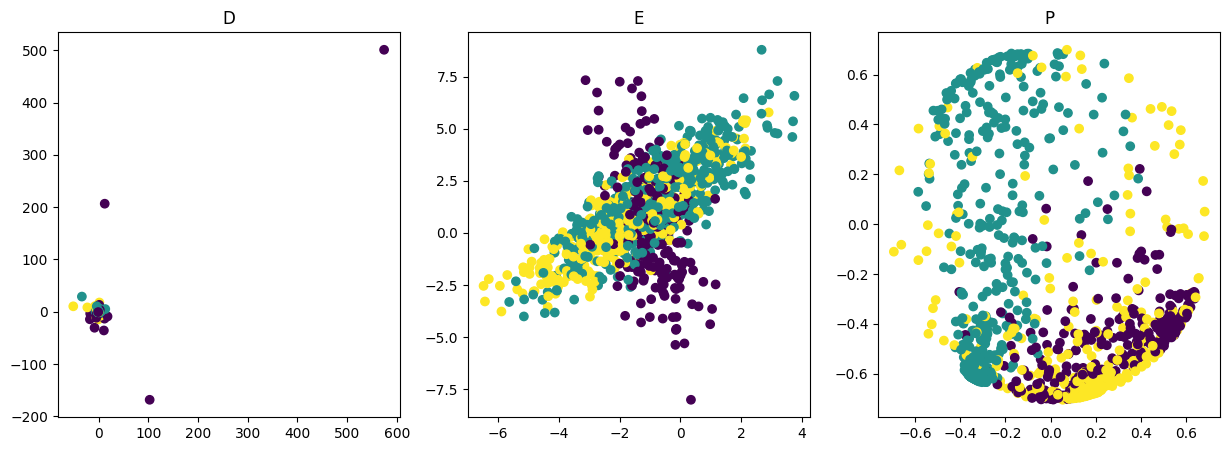

In [3]:
# Let's start with a basic product manifold
import embedders
import matplotlib.pyplot as plt
import torch

# Make a manifold
M = embedders.manifolds.ProductManifold(signature=[(2, 2), (0, 2), (-2, 2)])
S, E, H = M.P

# Get points
X, y = embedders.gaussian_mixture.gaussian_mixture(pm=M, num_classes=3)
X_S, X_E, X_H = M.factorize(X)

# Convert to stereographic
M_stereo, X_stereo = M.stereographic(X)
D, _, P = M_stereo.P
X_D, _, X_P = M_stereo.factorize(X_stereo)

# Let's also visualize our points
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, _X, title in zip(axs, [X_D, X_E, X_P], ["D", "E", "P"]):
    ax.scatter(_X[:, 0], _X[:, 1], c=y)
    ax.set_title(title)
plt.show()

In [4]:
def get_logits_old(self, man, X, W, b):
    """
    Computes logits given the manifold.

    Args:
        man: The manifold object, containing the curvature and relevant operations.
        X: Input points tensor of shape (n, d), where n is the number of points and d is the dimensionality.
        W: Weight tensor of shape (d, k), where k is the number of classes.
        b: Bias tensor of shape (k,).

    Returns:
        Logits: tensor of shape (n, k).
    """
    k = W.shape[1]
    n = X.shape[0]
    kappa = man.curvature
    logits = torch.zeros(n, k)
    for class_idx in range(k):
        # 0. Get parameters
        a_k = W[:, class_idx]
        p_k = b[class_idx]

        # 1. Let's get z_k = -p_k \oplus_\kappa x
        z_k = man.manifold.mobius_add(-p_k, X)

        # 2. Get norms for relevant terms
        z_k_norm = torch.norm(z_k)
        a_k_norm = torch.norm(a_k)

        # 3. Get the argument for sin_kappa^-1
        num = 2 * abs(kappa) ** 0.5 * man.manifold.inner(z_k, a_k)
        denom = (1 + kappa * z_k_norm**2) * a_k_norm
        arg = num / denom

        # 4. Get the right-hand side
        sin_kappa_inv = torch.asin if kappa >= 0 else torch.asinh
        rhs = sin_kappa_inv(arg)

        # 5. Get the left-hand side
        lambda_pk = man.manifold.lambda_x(p_k)
        lhs = lambda_pk * a_k_norm / abs(kappa) ** 0.5

        # 6. Get the logits
        logits[:, class_idx] = (lhs * rhs).flatten()

    return logits


get_logits(D, X_D, W, p_ks)

NameError: name 'get_logits' is not defined

In [ ]:
# How to vectorize mobius_add?
z_k = D.manifold.mobius_add(-p_ks[None, :], X_D[:, None])  # (n, k, d)
z_k_iter = torch.zeros_like(z_k)
for i, p_k in enumerate(p_ks):
    z_k_iter[:, i] = D.manifold.mobius_add(-p_k, X_D)
assert torch.allclose(z_k, z_k_iter)
print(z_k.shape)

# Norms are easy
z_k_norms = torch.norm(z_k_vec, dim=-1)  # (n, k)
print(z_k_norms.shape)
a_k_norms = torch.norm(W, dim=0)  # (k,)
print(a_k_norms.shape)

# Just let kappa be a scalar
kappa = D.curvature

# # 3. Get the argument for sin_kappa^-1
# num = 2 * abs(kappa) ** 0.5 * man.manifold.inner(z_k, a_k)
# denom = (1 + kappa * z_k_norm**2) * a_k_norm
# arg = num / denom

# Get the vectorized inner product of z_k and a_k
za_iter = torch.zeros(z_k.shape[:2])
for i, z_i in enumerate(z_k):  # n dims
    # for k, (z_k_i, W_k) in enumerate(zip(z_i, W.T)): # k dims
    for k in range(W.shape[1]):
        z_i_k = z_i[k]
        # print(z_i_k.shape) # (d,)
        W_k = W[:, k]
        # print(W_k.shape) # (d,)
        # za_iter[i, k] = D.manifold.inner(z_i_k, W_k)
        za_iter[i, k] = torch.dot(z_i_k, W_k)
za = torch.einsum("nkd,dk->nk", z_k, W)
assert torch.allclose(za, za_iter)

# Get the distance to the hyperplane
num = 2 * abs(kappa) ** 0.5 * za
denom = (1 + kappa * z_k_norms**2) * a_k_norms
arg = num / denom
print(arg.shape)  # (n, k)

# 4. Get the right-hand side
sin_kappa_inv = torch.asin if kappa >= 0 else torch.asinh
rhs = sin_kappa_inv(arg)
print(rhs.shape)  # (n, k)

# 5. Get the left-hand side
lambda_pks = D.manifold.lambda_x(p_ks)  # (k,)
lhs = lambda_pks * a_k_norms / abs(kappa) ** 0.5
print(lhs.shape)  # (k,)

# 6. Get the logits
logits = lhs * rhs
print(logits.shape)  # (n, k)

torch.Size([1000, 3, 2])
torch.Size([1000, 3])
torch.Size([3])
torch.Size([1000, 3])
torch.Size([1000, 3])
torch.Size([3])
torch.Size([1000, 3])


In [6]:
# Now that we've vectorized the operations and put them into the module, let's try them out

import embedders

kgcn = embedders.predictors.kappa_gcn.KappaGCN(in_features=2, out_features=3, manifold=D)
W = torch.nn.Parameter(torch.rand(2, 3))
p_ks = geoopt.ManifoldParameter(X_D[torch.randint(len(X_D), (3,))], manifold=D.manifold)

logits = kgcn.get_logits(X=X_D, W=W, b=p_ks)
print(logits.shape)

torch.Size([1000, 3])


In [13]:
# E = geoopt.manifolds.Stereographic(k=0)
# E = embedders.manifolds.ProductManifold(signature=[(0, 2)]).stereographic()[0].P[0] # get a Euclidean manifold
E = embedders.manifolds.Manifold(curvature=0, dim=2, stereographic=True)

kgcn = embedders.predictors.kappa_gcn.KappaGCN(in_features=2, out_features=3, manifold=E)
W = torch.nn.Parameter(torch.rand(2, 3))
p_ks = geoopt.ManifoldParameter(X_D[torch.randint(len(X_D), (3,))], manifold=E.manifold)

logits = kgcn.get_logits(X=X_D, W=W, b=p_ks)
print(logits.shape)

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1

In [12]:
logits

tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]], grad_fn=<MulBackward0>)

In [ ]:
# Let's do a quick product version

# We need to get a signed L2 norm of per-manifold distances, which is a little hacky
# Idea: the coefficients and distances can get L2 normed together
# All we need is to recover the sign of the inner product